In [ ]:
## making my own AHRS filter 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import integrate
from scipy import linalg
from scipy import interpolate
from scipy import optimize
from scipy import stats
from scipy import fftpack
from scipy import io
from scipy import constants

In [3]:
Ts = 0.01 # 100 Hz
P = np.array([[100,0,0],[0,100,0],[0,0,100]]) # initial covariance matrix
T = 50 # simulation time
t = np.arange(0,T,Ts) # time vector
P_array = np.zeros((3,3,len(t))) # covariance matrix array
Q = np.array([[0.1,0,0],[0,0.1,0],[0,0,0.1]])*1 # process noise covariance matrix
R = np.array([[0.01,0,0],[0,0.01,0],[0,0,0.01]])*10 # measurement noise covariance matrix
accel = pd.read_csv('acc.csv',header=None) # accelerometer data
accel.columns = ['time','ax','ay','az']
gyro = pd.read_csv('gyro.csv',header=None) # gyroscope data
gyro.columns = ['time','wx','wy','wz']
mag = pd.read_csv('mag.csv',header=None) # magnetometer data
mag.columns = ['time','mx','my','mz']
## init variables
x = np.zeros((3,len(t))) # state vector
x[:,0] = np.array([0,0,0]) # initial state
delta_x = np.zeros((3,len(t))) # state error vector
z = np.zeros((3,len(t))) # measurement vector
z[:,0] = np.array([0,0,0]) # initial measurement
x_prop = np.zeros((3,len(t))) # propagated state vector
# constants
g = 9.81 # gravity
# add noise to measurements
accel['ax'] = accel['ax'] + np.random.normal(0,R[0,0],len(accel['ax']))
accel['ay'] = accel['ay'] + np.random.normal(0,R[1,1],len(accel['ay']))
accel['az'] = accel['az'] + np.random.normal(0,R[2,2],len(accel['az']))
gyro['wx'] = gyro['wx'] + np.random.normal(0,R[0,0],len(gyro['wx']))
gyro['wy'] = gyro['wy'] + np.random.normal(0,R[1,1],len(gyro['wy']))
gyro['wz'] = gyro['wz'] + np.random.normal(0,R[2,2],len(gyro['wz']))
# add exp(0.01t) bias to gyro
gyro['wx'] = gyro['wx'] + np.exp(0.01*gyro['time'])
gyro['wy'] = gyro['wy'] + np.exp(0.01*gyro['time'])
gyro['wz'] = gyro['wz'] + np.exp(0.01*gyro['time'])


In [8]:
phi_meas = np.arctan2(-accel['ay'],-accel['az'])
theta_meas = np.arcsin(accel['ax']/g)
psi_meas = np.arctan2(-mag['my']*np.cos(phi_meas)+mag['mz']*np.sin(phi_meas), mag['mx']*np.cos(theta_meas) + mag['my']*np.sin(theta_meas)*np.sin(phi_meas) + mag['mz']*np.sin(theta_meas)*np.cos(phi_meas)) - 4.0266*np.pi/180

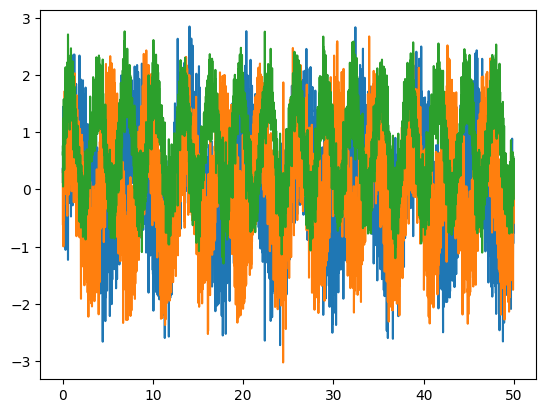

In [9]:
plt.plot(t,phi_meas*180/np.pi)
plt.plot(t,theta_meas*180/np.pi)
plt.plot(t,psi_meas*180/np.pi)

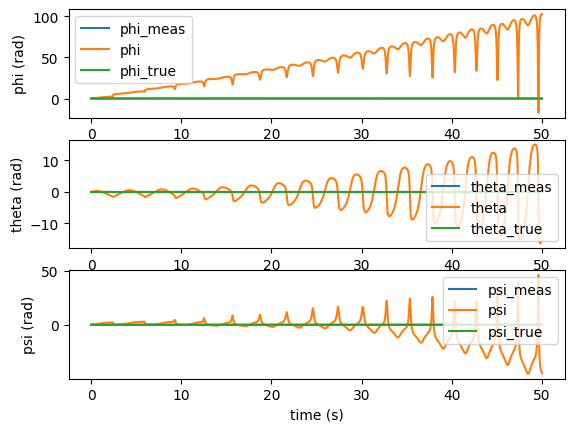

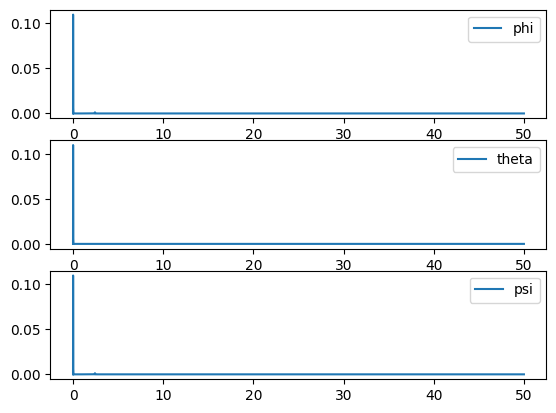

In [6]:
for i in range(len(t)-1):
    # propagate state
    phi = x_prop[0,i]
    theta = x_prop[1,i]
    psi = x_prop[2,i]
    x_prop[0, i+1] = phi + Ts*(gyro['wx'][i] + gyro['wy'][i]*np.sin(phi)*np.tan(theta) + gyro['wz'][i]*np.cos(phi)*np.tan(theta))
    x_prop[1, i+1] = theta + Ts*(gyro['wy'][i]*np.cos(phi) - gyro['wz'][i]*np.sin(phi))
    x_prop[2, i+1] = psi + Ts*(gyro['wy'][i]*np.sin(phi)/np.cos(theta) + gyro['wz'][i]*np.cos(phi)/np.cos(theta))
    # measurement update
    phi_meas = np.arctan2(-accel['ay'][i],-accel['az'][i])
    theta_meas = np.arcsin(accel['ax'][i]/g)
    psi_meas = np.arctan2(-mag['my'][i]*np.cos(phi_meas)+mag['mz'][i]*np.sin(phi_meas), mag['mx'][i]*np.cos(theta_meas) + mag['my'][i]*np.sin(theta_meas)*np.sin(phi_meas) + mag['mz'][i]*np.sin(theta_meas)*np.cos(phi_meas)) - 4.0266*np.pi/180

    z[:,i+1] = np.array([phi_meas,theta_meas,psi_meas])
    delta_ym = z[:,i+1] - x_prop[:,i+1]
    # kalman filter
    p = gyro['wx'][i]
    q = gyro['wy'][i]
    r = gyro['wz'][i]
    F = [[1+Ts*np.tan(theta)*(q*np.cos(phi)-r*np.sin(phi)), Ts*(q*np.sin(phi)+r*np.cos(phi))/(np.cos(theta)**2), 0],[Ts*(-q*np.sin(phi)-r*np.cos(phi)), 1, 0],[Ts*(q*np.cos(phi)-r*np.sin(phi))/np.cos(theta), Ts*np.sin(theta)*(q*np.sin(phi)+r*np.cos(phi))/np.cos(theta), 1]]
    delta_x[:,i+1] = np.dot(F,delta_x[:,i])
    Gamma = [[Ts, Ts*np.tan(theta)*np.sin(phi), Ts*np.tan(theta)*np.cos(phi)],[0, Ts*np.cos(phi), -Ts*np.sin(phi)],[0, Ts*np.sin(phi)/np.cos(theta), Ts*np.cos(phi)/np.cos(theta)]]
    P = np.dot(np.dot(F,P),np.transpose(F)) + np.dot(np.dot(Gamma,Q),np.transpose(Gamma))
    H = [[1,0,0],[0,1,0],[0,0,1]]
    delta_y = np.dot(H,delta_x[:,i+1])
    K = np.dot(np.dot(P,np.transpose(H)),linalg.inv(np.dot(np.dot(H,P),np.transpose(H))+R))
    delta_x[:,i+1] = delta_x[:,i+1] + np.dot(K,delta_ym-delta_y)
    P = np.dot(np.dot((np.identity(3)-np.dot(K,H)),P), np.transpose(np.dot((np.identity(3)-np.dot(K,H)),P))) + np.dot(np.dot(K,R),np.transpose(K))
    x[:,i+1] = x_prop[:,i+1] + delta_x[:,i+1]
    P_array[:,:,i+1] = P

# load true data
true = pd.read_csv('true.csv',header=None)
true.columns = ['time','phi','theta','psi']


plt.figure()
plt.subplot(3,1,1)
plt.plot(t,z[0,:],label='phi_meas')
plt.plot(t,x[0,:],label='phi')
plt.plot(t,true['phi'],label='phi_true')
plt.xlabel('time (s)')
plt.ylabel('phi (rad)')
plt.legend()
plt.subplot(3,1,2)
plt.plot(t,z[1,:],label='theta_meas')
plt.plot(t,x[1,:],label='theta')
plt.plot(t,true['theta'],label='theta_true')
plt.xlabel('time (s)')
plt.ylabel('theta (rad)')
plt.legend()
plt.subplot(3,1,3)
plt.plot(t,z[2,:],label='psi_meas')
plt.plot(t,x[2,:],label='psi')
plt.plot(t,true['psi'],label='psi_true')
plt.xlabel('time (s)')
plt.ylabel('psi (rad)')
plt.legend()
plt.show()


# plot P
plt.figure()
plt.subplot(3,1,1)
plt.plot(t,P_array[0,0,:],label='phi')
plt.legend()
plt.subplot(3,1,2)
plt.plot(t,P_array[1,1,:],label='theta')
plt.legend()
plt.subplot(3,1,3)
plt.plot(t,P_array[2,2,:],label='psi')
plt.legend()
plt.show()


In [7]:
# load model tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras import preprocessing
from tensorflow.keras import applications
from tensorflow.keras import datasets

# load model
model = models.load_model('model.h5')

In [8]:
# use model to predict kalman ahrs measurements
x_kalman = np.zeros((3,len(t))) 
x_kalman[:,0] = np.array([0,0,0]) # initial state

for i in range(len(t)-1):
    # propagate state
    phi = x_prop[0,i]
    theta = x_prop[1,i]
    psi = x_prop[2,i]
    x_prop[0, i+1] = phi + Ts*(gyro['wx'][i] + gyro['wy'][i]*np.sin(phi)*np.tan(theta) + gyro['wz'][i]*np.cos(phi)*np.tan(theta))
    x_prop[1, i+1] = theta + Ts*(gyro['wy'][i]*np.cos(phi) - gyro['wz'][i]*np.sin(phi))
    x_prop[2, i+1] = psi + Ts*(gyro['wy'][i]*np.sin(phi)/np.cos(theta) + gyro['wz'][i]*np.cos(phi)/np.cos(theta))
    # measurement update
    phi_meas = np.arctan2(-accel['ay'][i],-accel['az'][i])
    theta_meas = np.arcsin(accel['ax'][i]/g)
    psi_meas = np.arctan2(-mag['my'][i]*np.cos(phi_meas)+mag['mz'][i]*np.sin(phi_meas), mag['mx'][i]*np.cos(theta_meas) + mag['my'][i]*np.sin(theta_meas)*np.sin(phi_meas) + mag['mz'][i]*np.sin(theta_meas)*np.cos(phi_meas)) - 4.0266*np.pi/180

    # predict measurements from measurements and propagate state
    x_kalman[:,i+1] = model.predict(np.array([[phi_meas,theta_meas,psi_meas,phi,theta,psi]]))
    z[:,i+1] = x_kalman[:,i+1]
    delta_ym = z[:,i+1] - x_prop[:,i+1]
    # kalman filter
    p = gyro['wx'][i]
    q = gyro['wy'][i]
    r = gyro['wz'][i]
    F = [[1+Ts*np.tan(theta)*(q*np.cos(phi)-r*np.sin(phi)), Ts*(q*np.sin(phi)+r*np.cos(phi))/(np.cos(theta)**2), 0],[Ts*(-q*np.sin(phi)-r*np.cos(phi)), 1, 0],[Ts*(q*np.cos(phi)-r*np.sin(phi))/np.cos(theta), Ts*np.sin(theta)*(q*np.sin(phi)+r*np.cos(phi))/np.cos(theta), 1]]
    delta_x[:,i+1] = np.dot(F,delta_x[:,i])
    Gamma = [[Ts, Ts*np.tan(theta)*np.sin(phi), Ts*np.tan(theta)*np.cos(phi)],[0, Ts*np.cos(phi), -Ts*np.sin(phi)],[0, Ts*np.sin(phi)/np.cos(theta), Ts*np.cos(phi)/np.cos(theta)]]
    P = np.dot(np.dot(F,P),np.transpose(F)) + np.dot(np.dot(Gamma,Q),np.transpose(Gamma))
    H = [[1,0,0],[0,1,0],[0,0,1]]
    delta_y = np.dot(H,delta_x[:,i+1])
    K = np.dot(np.dot(P,np.transpose(H)),linalg.inv(np.dot(np.dot(H,P),np.transpose(H))+R))
    delta_x[:,i+1] = delta_x[:,i+1] + np.dot(K,delta_ym-delta_y)
    P = np.dot(np.dot((np.identity(3)-np.dot(K,H)),P), np.transpose(np.dot((np.identity(3)-np.dot(K,H)),P))) + np.dot(np.dot(K,R),np.transpose(K))
    x[:,i+1] = x_prop[:,i+1] + delta_x[:,i+1]
    P_array[:,:,i+1] = P

1/1 [==============================] - 0s 19ms/step


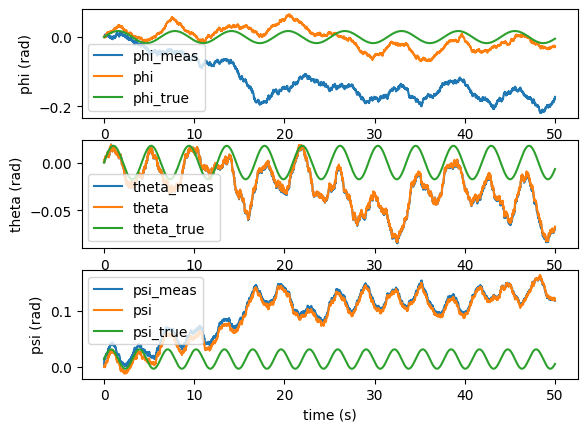

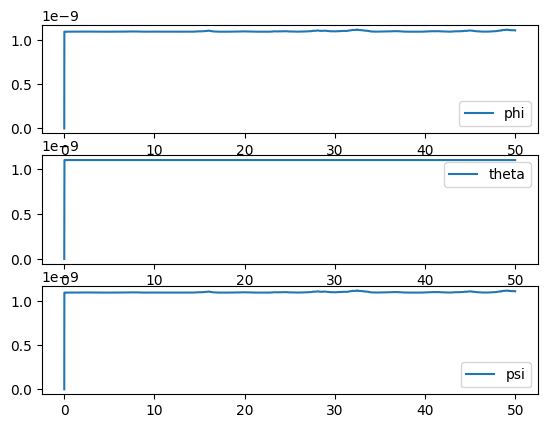

In [9]:
# load true data
true = pd.read_csv('true.csv',header=None)
true.columns = ['time','phi','theta','psi']


plt.figure()
plt.subplot(3,1,1)
plt.plot(t,z[0,:],label='phi_meas')
plt.plot(t,x[0,:],label='phi')
plt.plot(t,true['phi'],label='phi_true')
plt.xlabel('time (s)')
plt.ylabel('phi (rad)')
plt.legend()
plt.subplot(3,1,2)
plt.plot(t,z[1,:],label='theta_meas')
plt.plot(t,x[1,:],label='theta')
plt.plot(t,true['theta'],label='theta_true')
plt.xlabel('time (s)')
plt.ylabel('theta (rad)')
plt.legend()
plt.subplot(3,1,3)
plt.plot(t,z[2,:],label='psi_meas')
plt.plot(t,x[2,:],label='psi')
plt.plot(t,true['psi'],label='psi_true')
plt.xlabel('time (s)')
plt.ylabel('psi (rad)')
plt.legend()
plt.show()


# plot P
plt.figure()
plt.subplot(3,1,1)
plt.plot(t,P_array[0,0,:],label='phi')
plt.legend()
plt.subplot(3,1,2)
plt.plot(t,P_array[1,1,:],label='theta')
plt.legend()
plt.subplot(3,1,3)
plt.plot(t,P_array[2,2,:],label='psi')
plt.legend()
plt.show()